In [1]:
! pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\Users\parsa\AppData\Local\Programs\Python\Python312\Lib\site-packages\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\parsa\AppData\Local\Programs\Python\Python312\Lib\site-packages\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\parsa\AppData\Local\Programs\Python\Python312\Lib\site-packages\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

C:\Users\parsa\AppData\Local\Temp\ipykernel_216\989332610.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# dont use all gpu just a mount your need 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

Remove dodgy images

In [5]:
data_dir = 'data'

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Load Data

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1121 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [94]:
batch = data_iterator.next()

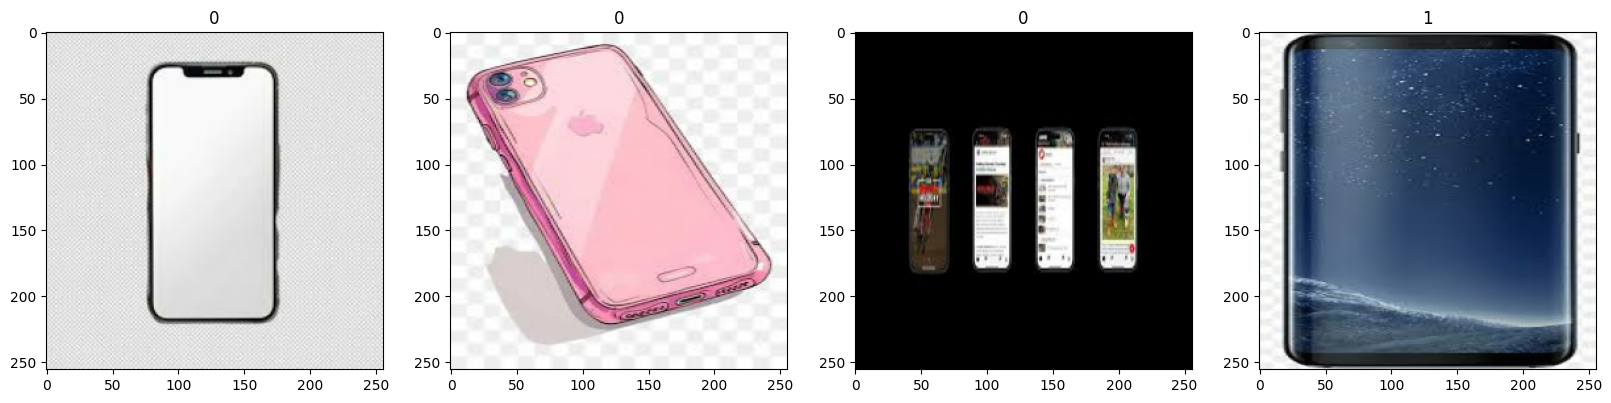

In [95]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scale Data

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

 Split Data

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [15]:
train_size

25

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build Deep Learning Model

In [17]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import BatchNormalization

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\parsa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,711,793 (14.16 MB)

 Trainable params: 3,711,793 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [23]:
logdir='logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.4929 - loss: 0.8258 - val_accuracy: 0.5491 - val_loss: 0.6889
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.5528 - loss: 0.6815 - val_accuracy: 0.5714 - val_loss: 0.6820
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.6537 - loss: 0.6515 - val_accuracy: 0.6607 - val_loss: 0.6137
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.7514 - loss: 0.5249 - val_accuracy: 0.6473 - val_loss: 0.5990
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.7515 - loss: 0.4569 - val_accuracy: 0.8125 - val_loss: 0.4648
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.8389 - loss: 0.3486 - val_accuracy: 0.7321 - val_loss: 0.5031
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.8984 - loss: 0.2198 - val_accuracy: 0.8348 - val_loss: 0.4237
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.9317 - loss: 0.1884 - val_accuracy: 0.8080 - v

Plot Performance

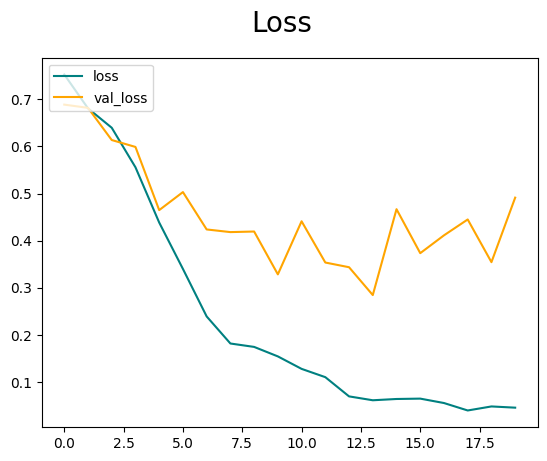

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

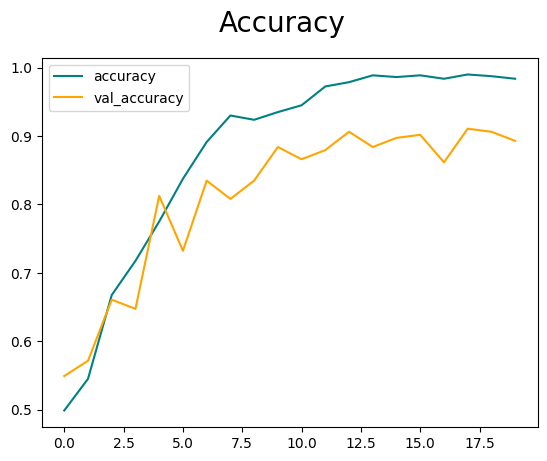

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<Axes: >

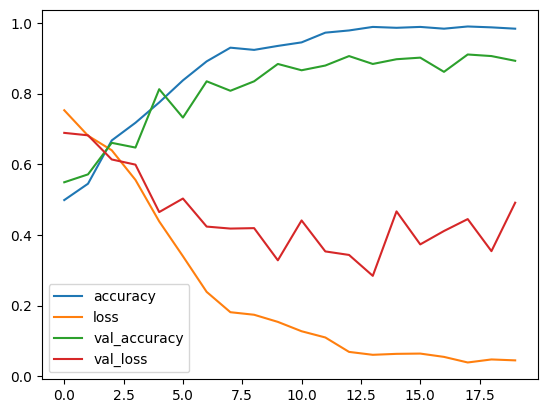

In [34]:

pd.DataFrame(hist.history).plot()

Evaluate

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.95238096, shape=(), dtype=float32) tf.Tensor(0.81632656, shape=(), dtype=float32) tf.Tensor(0.8854167, shape=(), dtype=float32)


In [39]:
import cv2

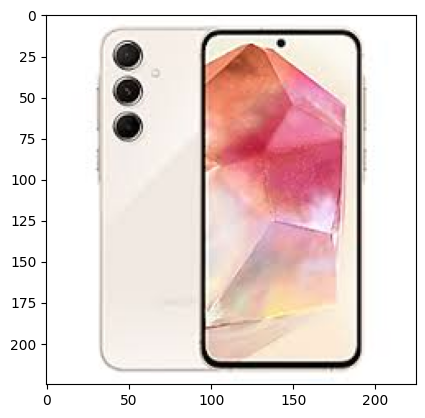

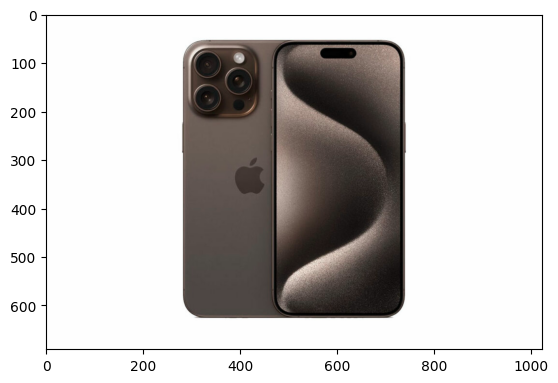

In [64]:
img = cv2.imread('images.jpg')
plt.imshow(img)
plt.show()

imge = cv2.imread('Apple-iPhone-15-Pro-Max.jpg')
plt.imshow(imge)
plt.show()

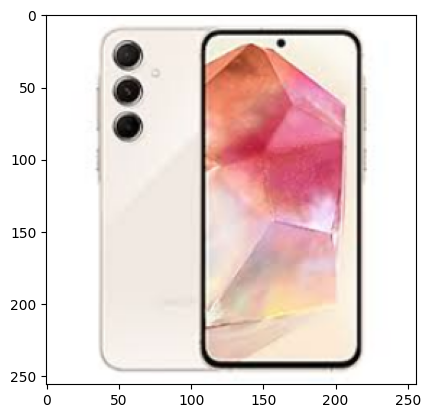

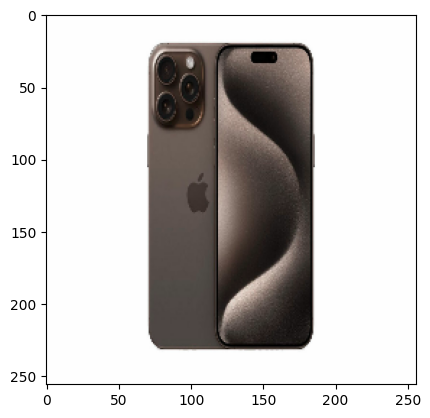

In [67]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

resizee = tf.image.resize(imge, (256,256))
plt.imshow(resizee.numpy().astype(int))
plt.show()


In [68]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhatt = model.predict(np.expand_dims(resizee/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [70]:
print(yhat)
print(yhatt)

[[0.9963358]]
[[0.06232266]]


In [71]:
if yhat > 0.5: 
    print(f'Predicted class is sumsung')
else:
    print(f'Predicted class is iphone')

if yhatt > 0.5: 
    print(f'Predicted class is sumsung')
else:
    print(f'Predicted class is iphone')    

Predicted class is sumsung
Predicted class is iphone


In [96]:
from tensorflow.keras.models import load_model

In [97]:
model.save(os.path.join('models','imageclassifier.h5'))

In [99]:
new_model = load_model('models/imageclassifier.h5')

In [100]:

new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


array([[0.9963358]], dtype=float32)